# Notebook Imports

In [2]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
# from wordcloud import WordCloud
from PIL import Image
import numpy as np

%matplotlib inline

In [3]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [5]:
type(message)

str

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2
#yield keyword id different from return, the function here remembers where it left off

In [8]:
for i in generate_squares(5):
    print(i, end='->')
    
#Now we will use this generator function to read all the emails we have at one call

0->1->4->9->16->

# Email body extraction 

In [9]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        #Walk is a built in function used which goes trough all the files and returns these three as a tuple
        #We are going to use all the filenames in the easy_ham_1 file by extracting via the walk
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

        
    #walk function here goes through each email one by one

In [10]:
def df_from_directory(path, classification):
    rows =[]
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'Message':email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index = row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,Message,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [14]:
ham_emails.shape

(3901, 2)

In [15]:
data = pd.concat([spam_emails, ham_emails])
data.shape

(5799, 2)

In [16]:
data.head()

,Message,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


# Data Cleaning: Checking for missing values

In [20]:
#checking if any message bodies are null
#data['Message'].isnull()
#data['Message'].isnull().values
data['Message'].isnull().values.any()
#the .values attribute gives us an array and .any checks

False

In [20]:
my_var = None
type(my_var)

NoneType

In [21]:
#check if there are any empy emails(string length = 0)
(data.Message.str.len()==0).any()

True

In [22]:
(data.Message.str.len()==0).sum()
#this is us adding boolean values, so if any of the emails would have been empty we would have recieved a non-zero sum
#hence inference that all emails are not empty

3

In [23]:
# Challenge: how would you check the number of entries with null/None values?
data.Message.isnull().sum()

0

### Locate empty emails

In [24]:
type(data.Message.str.len()==0)

pandas.core.series.Series

In [25]:
data[data.Message.str.len()==0].index

#If there were any empty mails we would have got it in the output...

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File Enteries from DataFrame

In [26]:
#data = data.drop(['cmds'])
data.drop(['cmds'], inplace = True)

#Both of them do the same job, in first method we assign the data again and the second one we use inplace

In [27]:
data.shape

(5796, 2)

# Add document IDs to Track Emails in Dataset

In [28]:
document_ids = range(0, len(data.index))
data['DOC_ID']=document_ids

In [29]:
data.DOC_ID

00249.5f45607c1bffe89f60ba1ec9f878039a       0
00373.ebe8670ac56b04125c25100a36ab0510       1
00214.1367039e50dc6b7adb0f2aa8aba83216       2
00210.050ffd105bd4e006771ee63cabc59978       3
00033.9babb58d9298daa2963d4f514193d7d6       4
                                          ... 
00609.dd49926ce94a1ea328cce9b62825bc97    5791
00957.e0b56b117f3ec5f85e432a9d2a47801f    5792
01127.841233b48eceb74a825417d8d918abf8    5793
01178.5c977dff972cd6eef64d4173b90307f0    5794
00747.352d424267d36975a7b40b85ffd0885e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [30]:
#Make a new column with file names and name it as index
data['FILE NAME'] = data.index
#Update the column and keep DOC_ID as index
data.set_index('DOC_ID', inplace=True)
data

,Message,CATEGORY,FILE NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,"I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
5792,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,01127.841233b48eceb74a825417d8d918abf8


# Save to File using Pandas

In [31]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [21]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [22]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

([<matplotlib.patches.Wedge at 0x7ff720616910>,
 [Text(-0.9420286857031652, 0.5679629876253974, 'Spam'),
  Text(0.9420286857031651, -0.5679629876253975, 'Legit Mail')],
 [Text(-0.5138338285653629, 0.3097979932502168, '32.73%'),
  Text(0.5138338285653627, -0.30979799325021684, '67.27%')])

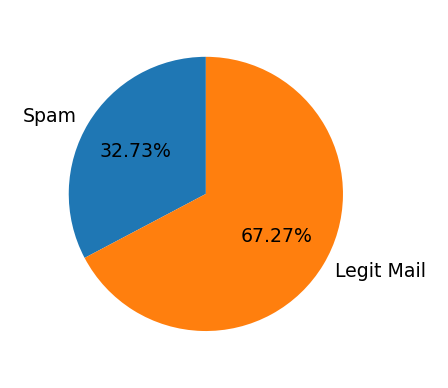

In [24]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
plt.figure(figsize=(2, 2), dpi=227 )
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,autopct='%1.2f%%')

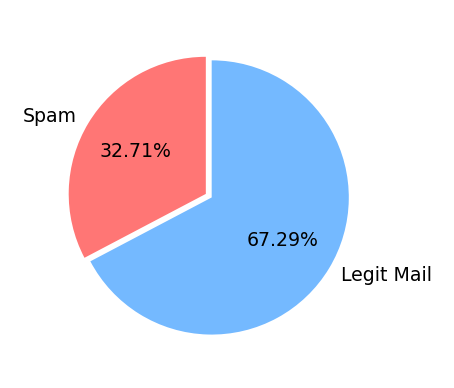

In [35]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,autopct='%1.2f%%', 
       colors=['#ff7675', '#74b9ff'], explode=[0,0.05])
plt.show()

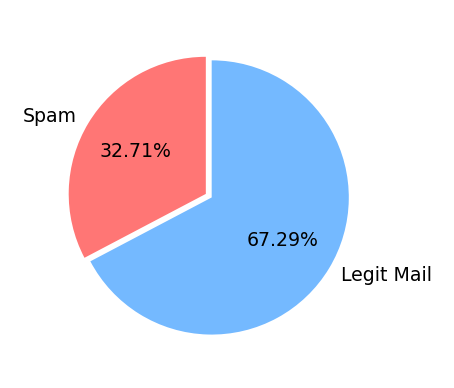

In [36]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,autopct='%1.2f%%', 
       colors=['#ff7675', '#74b9ff'], explode=[0,0.05])
plt.show()

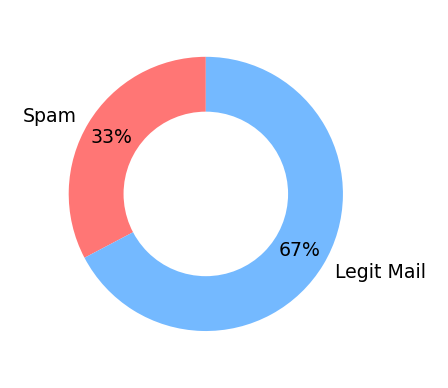

In [37]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

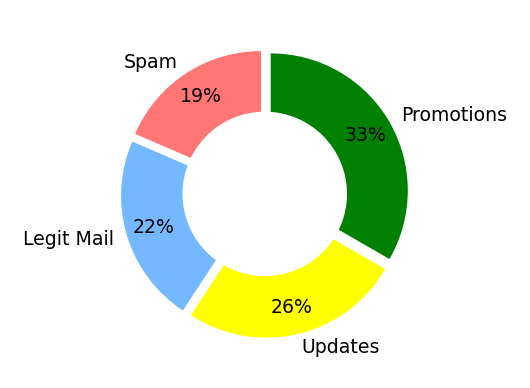

In [38]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [55,66,77,99]
custom_colours = ['#ff7675', '#74b9ff', 'yellow', 'green']
abc=[0.05,0.05,0.05,0.05]
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=abc)

# draw circle
centre_circle= plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [39]:
# convert to lower case
msg = 'All WoRK and NO PlaY makeS JaCK a DUll Boy'
msg=msg.lower()

### Download the NLTK Resources (Tokenizer and Stop Words)

In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adityasomani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adityasomani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/adityasomani/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /Users/adityasomani/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

# Tokenizing

In [43]:
word_tokenize(msg)

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

# Removing Stop Words

In [44]:
#Now we have to check
#Best is to use set for this,- unordered list with each item occuring only one time, so very efficient for checking membership

In [45]:
type(stopwords.words('english'))
#so to convers to set
stop_words = set(stopwords.words('english'))

In [46]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words=[]

#Important loop
for word in words:
    if word not in stop_words :
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


# Word Stemming

In [47]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

filtered_words=[]

#stemmer = PorterStemmer
stemmer = SnowballStemmer('english')
#Important loop
for word in words:
    if word not in stop_words :
        if word.isalpha():
            stemmed_word=stemmer.stem(word)
            filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


In [48]:
#is aplha is a method used to check character or puntuation
'p'.isalpha()

True

In [49]:
'?'.isalpha()

False

 # Removing HTML Tags from Emails

In [50]:

soup = BeautifulSoup(data.at[2, 'Message'], 'html.parser')
print(soup.prettify())

This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout
<http: optout="" www.insuranceiq.com

In [51]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

## Functions for Email Processing

In [52]:
def clean_message(message, stemmer = PorterStemmer(),
                 stop_words = set(stopwords.words('english'))):
    # Converts to Lower Case and splits up the words
  
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
        return filtered_words

In [53]:
clean_message(email_body)


['dear']

In [54]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [55]:
clean_msg_no_html(data.at[2, 'Message'])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'dare',
 'find',
 'better',
 'annuiti',
 'call',
 'today',
 'inform',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'sent',
 'insur',
 'profession',
 'remov',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic']

# Applying Cleaning and Tokenizing to all messages

### Slicing Dataframes and Series and Creating Subsets

In [56]:
data.iat[2,0]
#With data.at we work using Column name and with data.iat we use the location

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

In [57]:
data.iloc[0:]

,Message,CATEGORY,FILE NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,"I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
5792,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,01127.841233b48eceb74a825417d8d918abf8


In [58]:
first_emails = data.Message.iloc[0:3]

nested_list = first_emails.apply(clean_message)


In [59]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

#both the codes do the same job

In [60]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.Message.apply(clean_msg_no_html)

/Users/adityasomani/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 25.5 s, sys: 65.4 ms, total: 25.6 s
Wall time: 25.6 s


In [61]:
nested_list.head()

DOC_ID
0    [dear, homeown, interest, rate, lowest, point,...
1    [attent, must, comput, user, packag, deal, nor...
2    [messag, mime, format, dare, tri, find, better...
3    [import, inform, new, domain, name, final, ava...
4    [bottom, line, give, away, cd, free, peopl, li...
Name: Message, dtype: object

### Using Logic to Slice Dataframes

In [62]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [63]:
data[data.CATEGORY == 1].tail()

,Message,CATEGORY,FILE NAME
DOC_ID,,,
1891,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,01311.43bfe86df65d53c5f7ca2365dc12582b
1892,<html>\n\n<HEAD> \n\n<TITLE>creditfix</TITLE> ...,1,00851.dc5452f80ba0bb8481dfc48f70380c4d
1893,Hello:\n\n\n\nAre you satisfied with your ISP?...,1,01328.b23902de23cb3ca1f3334517282372b2
1894,<html><HEAD><TITLE>creditfix</TITLE> \n\n</HEA...,1,01244.9ef966101737a6fc27d8965def288d70
1895,<HTML><HEAD></HEAD><BODY><b><FONT SIZE=3D4>In ...,1,00788.b98a23c07d59156d172683fc29b80661


In [64]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

## Subsetting a series with an index

In [65]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [66]:
type(nested_list)

pandas.core.series.Series

In [67]:
#Now to make a smaller list with only ham mails
nested_list_ham = nested_list.loc[doc_ids_ham]

In [68]:
nested_list_ham.shape

(3900,)

In [69]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [70]:
nested_list_spam.shape

(1896,)

In [71]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham)

normal_words.shape[0] #total number of words

442061

In [72]:
normal_words.value_counts()[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [73]:
normal_words.value_counts().shape[0]

20815

In [74]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam)

spammy_words.shape[0] #total number of words

317499

In [75]:
spammy_words.value_counts()[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

In [76]:
spammy_words.value_counts().shape[0]

13242

## Creating a wordcloud

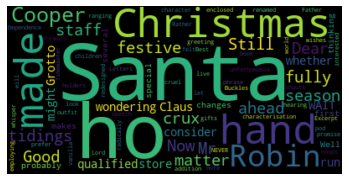

In [215]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [216]:
#I got in some novels from nltk
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [217]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [218]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [219]:
word_list = [''.join(word) for word in example_corpus]
word_list

['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.',
 '(',
 'Supplied',
 'by',
 'a',
 'Late',
 'Consumptive',
 'Usher',
 'to',
 'a',
 'Grammar',
 'School',
 ')',
 'The',
 'pale',
 'Usher',
 '--',
 'threadbare',
 'in',
 'coat',
 ',',
 'heart',
 ',',
 'body',
 ',',
 'and',
 'brain',
 ';',
 'I',
 'see',
 'him',
 'now',
 '.',
 'He',
 'was',
 'ever',
 'dusting',
 'his',
 'old',
 'lexicons',
 'and',
 'grammars',
 ',',
 'with',
 'a',
 'queer',
 'handkerchief',
 ',',
 'mockingly',
 'embellished',
 'with',
 'all',
 'the',
 'gay',
 'flags',
 'of',
 'all',
 'the',
 'known',
 'nations',
 'of',
 'the',
 'world',
 '.',
 'He',
 'loved',
 'to',
 'dust',
 'his',
 'old',
 'grammars',
 ';',
 'it',
 'somehow',
 'mildly',
 'reminded',
 'him',
 'of',
 'his',
 'mortality',
 '.',
 '"',
 'While',
 'you',
 'take',
 'in',
 'hand',
 'to',
 'school',
 'others',
 ',',
 'and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale',
 '-',
 'fish',
 'is',
 'to',
 'be',
 

In [220]:
novel_as_string = ' '.join(word_list)
novel_as_string

# All of this is done so that we can feed the wordcloud a simple string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

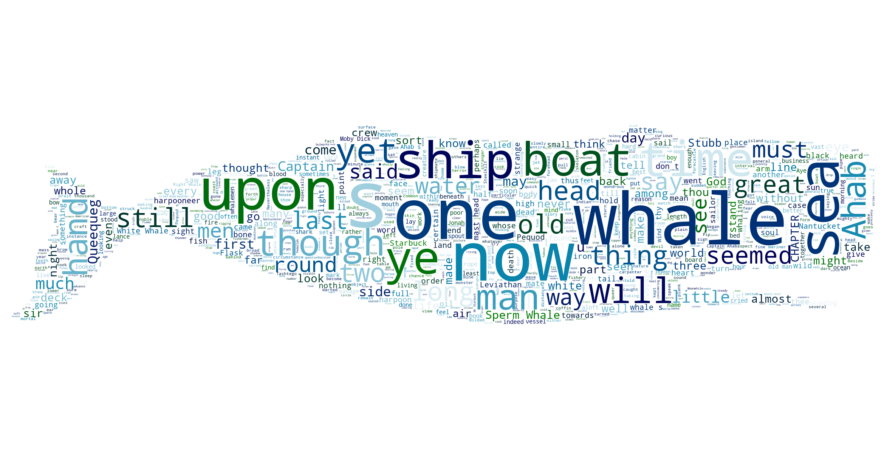

CPU times: user 8.61 s, sys: 304 ms, total: 8.92 s
Wall time: 9.3 s


In [221]:
%%time
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array as the mask function reqires input as array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=1000, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')#try some by shift+tab and bilinear fits best
plt.axis('off')
plt.show()


In [222]:
rgb_array.shape

(1024, 2048, 3)

In [223]:
rgb_array[1023, 2047]
#white

array([255, 255, 255], dtype=uint8)

In [224]:
rgb_array[500, 1000]
#black

array([0, 0, 0], dtype=uint8)

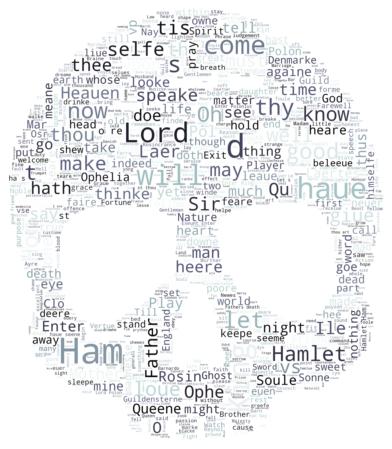

CPU times: user 20.2 s, sys: 921 ms, total: 21.1 s
Wall time: 22.1 s


In [225]:
%%time
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      colormap='bone', max_words=1000)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud of Ham and Spam messages

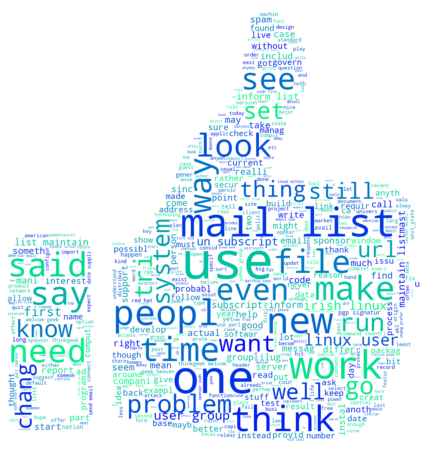

In [226]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

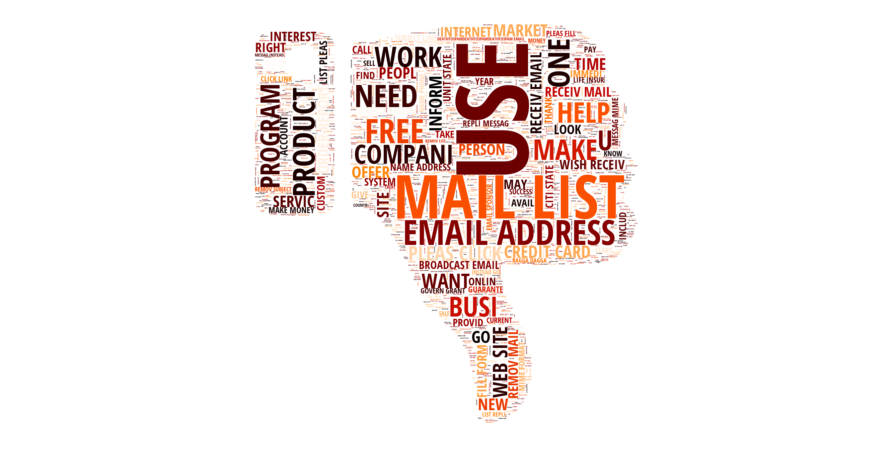

In [227]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())#Converting to upper case

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Markdown and Dictionary

In [77]:
stemmed_nested_list = data.Message.apply(clean_msg_no_html)
flat_stemmed_list =[item for sublist in stemmed_nested_list for item in sublist ]

/Users/adityasomani/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [78]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
unique_words.shape[0]

27334

In [79]:
frequent_words = unique_words[0:VOCAB_SIZE]
frequent_words

http       10660
use         5019
list        4851
email       4367
get         4200
           ...  
contest       44
chosen        43
born          43
steven        43
fake          43
Length: 2500, dtype: int64

In [80]:
type(frequent_words)

pandas.core.series.Series

## Create Vocabulary Dataframe with a WORD_ID

In [81]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


### Save vocab as a CSV file

In [82]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)
#Here we are able to link by providing the index_label and header straightaway from Vocab

# Exercise: Checking if a Word is Part of the Vocabulary

In [83]:
# Challenge: Write a line of code that checks if a particular word is part 
# of the vocabulary. Your code should return True if the word is among the 
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [84]:
any(vocab.VOCAB_WORD=='machine')
#The inefficient way

False

In [85]:
#Set method
'machine' in set(vocab.VOCAB_WORD)
#Much faster...

False

# Exercise: Find the Email with the Most Number of Words

In [86]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# Hint: use the len() function and practice list comprehension

In [87]:

# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

print(clean_email_lengths)

[50, 80, 92, 77, 141, 1, 46, 133, 23, 74, 489, 46, 110, 130, 2, 72, 146, 45, 223, 178, 14, 97, 37, 98, 0, 263, 26, 835, 205, 48, 53, 50, 90, 740, 83, 78, 36, 34, 78, 36, 40, 0, 2, 203, 55, 10, 90, 90, 104, 18, 90, 104, 15, 58, 9, 119, 36, 226, 108, 389, 206, 249, 1262, 1221, 247, 34, 110, 748, 252, 77, 57, 198, 84, 38, 42, 81, 0, 269, 70, 95, 96, 79, 247, 80, 43, 74, 132, 90, 38, 9, 79, 208, 6, 177, 142, 25, 224, 0, 235, 133, 20, 14, 49, 104, 70, 664, 195, 317, 126, 108, 5, 223, 153, 8, 55, 372, 56, 97, 35, 115, 111, 25, 258, 835, 81, 86, 408, 26, 90, 90, 108, 673, 1390, 100, 175, 33, 329, 52, 65, 100, 64, 330, 2, 41, 3, 157, 147, 8, 97, 3, 27, 135, 1171, 80, 75, 20, 183, 275, 217, 333, 102, 50, 183, 19, 72, 217, 218, 61, 80, 114, 79, 63, 177, 44, 1183, 47, 661, 166, 13, 210, 58, 92, 124, 81, 78, 104, 89, 509, 509, 187, 84, 18, 118, 50, 0, 93, 157, 0, 47, 161, 62, 0, 6083, 208, 40, 61, 14, 182, 84, 15, 185, 241, 144, 52, 93, 255, 72, 131, 216, 167, 38, 360, 82, 67, 214, 102, 0, 204, 3,

In [88]:
#Python list comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [89]:
print('Email position in the list(and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list(and the data dataframe) 5401


In [90]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [91]:
data.at[np.argmax(clean_email_lengths), 'Message']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [92]:
type(stemmed_nested_list)

pandas.core.series.Series

In [93]:
type(stemmed_nested_list.tolist())
# Converting it to a python list

list

In [94]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5791,one,work,well,week,te,updat,server,sync,messag,jordan,...,None,None,None,None,None,None,None,None,None,None
5792,damien,morton,quot,approv,html,abl,say,feel,rockal,time,...,None,None,None,None,None,None,None,None,None,None
5793,mon,che,wrote,that,correct,line,ad,repositori,instal,still,...,None,None,None,None,None,None,None,None,None,None
5794,upon,time,manfr,wrote,would,like,instal,rpm,tri,get,...,None,None,None,None,None,None,None,None,None,None


In [95]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [96]:
# Challenge: Can you split the data into a training and testing set? Set the test size at 30%. 
# The training data should include 4057 emails. Use a seed value of 42 to shuffle the data. 
# What should the target values be? 

In [97]:
 X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [98]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [99]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None


In [100]:
y_train.head()
#see that the ids do match

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [101]:
word_index = pd.Index(vocab.VOCAB_WORD)


In [102]:
 word_index.get_loc('thu')
#Very very important method

392

In [103]:
X_train.index[0]


4844

In [104]:
y_train.at[4844]

0

In [105]:
word_index.get_loc('rodent')
#We get an error cause this word did not appear often enough to come in the top 2500 words

KeyError: 'rodent'

In [106]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)

    """
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [107]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 5min 56s, sys: 700 ms, total: 5min 56s
Wall time: 7min 47s


In [108]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,392
1,0,4844,1,492
2,0,4844,1,2368
3,0,4844,1,497
4,0,4844,1,37


In [109]:
sparse_train_df.shape

(444959, 4)

 ### Combine Occurrences with the Pandas groupby() Method

In [110]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       7       1              1
       16      1              1
       18      1              1
       24      1              1

In [111]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [112]:
data.Message[0]

'Dear Homeowner,\n\n \n\nInterest Rates are at their lowest point in 40 years!\n\n\n\nWe help you find the best rate for your situation by\n\nmatching your needs with hundreds of lenders!\n\n\n\nHome Improvement, Refinance, Second Mortgage,\n\nHome Equity Loans, and More! Even with less than\n\nperfect credit!\n\n\n\nThis service is 100% FREE to home owners and new\n\nhome buyers without any obligation. \n\n\n\nJust fill out a quick, simple form and jump-start\n\nyour future plans today!\n\n\n\n\n\nVisit http://61.145.116.186/user0201/index.asp?Afft=QM10\n\n\n\n\n\n\n\n\n\n\n\n\n\nTo unsubscribe, please visit:\n\n\n\nhttp://61.145.116.186/light/watch.asp\n\n\n\n\n'

In [113]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,7,1,1
2,0,16,1,1
3,0,18,1,1
4,0,24,1,1


In [114]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
265565,5795,1837,0,1
265566,5795,1903,0,2
265567,5795,2111,0,1
265568,5795,2267,0,1
265569,5795,2480,0,1


In [115]:
vocab.at[1895, 'VOCAB_WORD']

'harm'

In [116]:
train_grouped.shape

(265570, 4)

### Save Training Data as .txt File

In [117]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt = '%d')

In [118]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Challenge

In [119]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 2min 35s, sys: 516 ms, total: 2min 35s
Wall time: 2min 37s


In [121]:
sparse_test_df.shape

(187650, 4)

In [122]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,21,1,2
4,8,26,1,1


In [123]:
test_grouped.shape

(110568, 4)

In [124]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt = '%d')

In [125]:
test_grouped['DOC_ID'].unique()

array([   8,   12,   15, ..., 5788, 5792, 5793])

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [126]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [127]:
len(test_doc_ids)

1723

In [128]:
len(X_test)

1739

In [129]:
#To get the emails that were not included, the best way easily is to use sets


set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

{14,
 325,
 416,
 445,
 452,
 479,
 576,
 594,
 681,
 856,
 859,
 1001,
 1042,
 1109,
 1361,
 1407}

In [130]:
data.Message[325]

#We are probably facing some problem with the data type we are using


'------=_NextPart_000_00C5_44B43D7A.C5027E65\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nQVRURU5USU9OOiBUaGlzIGlzIGEgTVVTVCBmb3IgQUxMIENvbXB1dGVyIFVz\n\nZXJzISEhDQoNCipORVctU3BlY2lhbCBQYWNrYWdlIERlYWwhKg0KDQpOb3J0\n\nb24gU3lzdGVtV29ya3MgMjAwMiBTb2Z0d2FyZSBTdWl0ZSAtUHJvZmVzc2lv\n\nbmFsIEVkaXRpb24tDQoNCkluY2x1ZGVzIFNpeCAtIFllcyA2ISAtIEZlYXR1\n\ncmUtUGFja2VkIFV0aWxpdGllcw0KQUxMIEZvciAxIFNwZWNpYWwgTE9XIFBy\n\naWNlIQ0KDQpUaGlzIFNvZnR3YXJlIFdpbGw6DQotIFByb3RlY3QgeW91ciBj\n\nb21wdXRlciBmcm9tIHVud2FudGVkIGFuZCBoYXphcmRvdXMgdmlydXNlcw0K\n\nLSBIZWxwIHNlY3VyZSB5b3VyIHByaXZhdGUgJiB2YWx1YWJsZSBpbmZvcm1h\n\ndGlvbg0KLSBBbGxvdyB5b3UgdG8gdHJhbnNmZXIgZmlsZXMgYW5kIHNlbmQg\n\nZS1tYWlscyBzYWZlbHkNCi0gQmFja3VwIHlvdXIgQUxMIHlvdXIgZGF0YSBx\n\ndWljayBhbmQgZWFzaWx5DQotIEltcHJvdmUgeW91ciBQQydzIHBlcmZvcm1h\n\nbmNlIHcvc3VwZXJpb3IgaW50ZWdyYWwgZGlhZ25vc3RpY3MhDQoNCjYgRmVh\n\ndHVyZS1QYWNrZWQgVXRpbGl0aWVzLi4uMSBHcmVhdCBQcmljZSENCkEgJDMw\n\nMCsgQ29tYmluZWQgUmV0YWlsI

In [131]:
#as this email looks weird, we open it in text editor
data.loc[14]

Message      ------=_NextPart_000_00A3_65E24E1C.A3468E63\n\...
CATEGORY                                                     1
FILE NAME               00095.17594a58d6736a8f6a1990b0b92090cd
Name: 14, dtype: object

In [132]:
#Checking via clean function
clean_msg_no_html(data.at[14, 'Message'])

['kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr',
 'kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr']